In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import typing
from typing import Type

import numpy as np
import torch

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
import devinterp.utils as utils

import re
import yaml
from dataclasses import dataclass


from dgp import get_dataloader
from model import GPT

import torch.nn.functional as F
from utils import move_to_device

import pickle
import os

from utils.io import Conf
from utils.llc import calculate_llc_for_file, evaluate_fn

from functools import partial

In [3]:
hf_repo_name = "px47qrx5"
model_dir = f'results/scratch/{hf_repo_name}'

In [4]:
config = Conf.load_from_yaml("config/conf.yaml")
config.device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = get_dataloader(
    n_relative_properties=config.data.n_relative_properties,
    n_descriptive_properties=config.data.n_descriptive_properties,
    n_descriptive_values=config.data.n_descriptive_values,
    num_of_classes_to_divide_over=config.data.num_of_classes_to_divide_over,
    prior_param=config.data.prior_param,
    props_prior_type=config.data.props_prior_type,
    n_entities=config.data.n_entities,
    instr_ratio=config.data.instr_ratio,
    max_sample_length=config.data.max_sample_length,
    num_iters=config.data.num_iters * config.data.batch_size,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers,
    seed=config.seed,
)

pad_token_id = dataloader.dataset.pad_token_id

evaluator = partial(evaluate_fn, pad_token_id=pad_token_id, config=config)

In [5]:
num_chains = 5
num_draws = 150
iteration = 1000
gammas = [50, 100.0, 200.0, 400.0, 800.0]
eps = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
llcs = {}
# grid sweep
for e in eps:
    for g in gammas:
        print(f"e: {e}, g: {g}")
        llc = calculate_llc_for_file(
            iteration=iteration,
            dataloader=dataloader,
            model_dir=model_dir,
            config=config,
            evaluate_fn=evaluator,
            optimizer_kwargs=dict(lr=e, localization=g, nbeta=30),
            num_chains=num_chains,
            num_draws=num_draws,
        )
        llcs[(e, g)] = llc

e: 0.0005, g: 100.0


/workspace/ConceptPercolation/utils/io.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f"{dirname}/{fname}", map_location=device)
/workspace/ConceptPe

e: 0.0005, g: 200.0


/workspace/ConceptPercolation/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:211: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/workspace/ConceptPercolation/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:234: UserWarning: If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
Chain 7: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


e: 0.0005, g: 400.0


Chain 7: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


e: 0.001, g: 100.0


Chain 7: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


e: 0.001, g: 200.0


Chain 7: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


e: 0.001, g: 400.0


Chain 7: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


e: 0.005, g: 100.0


Chain 7: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


e: 0.005, g: 200.0


Chain 7: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


e: 0.005, g: 400.0


Chain 7: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


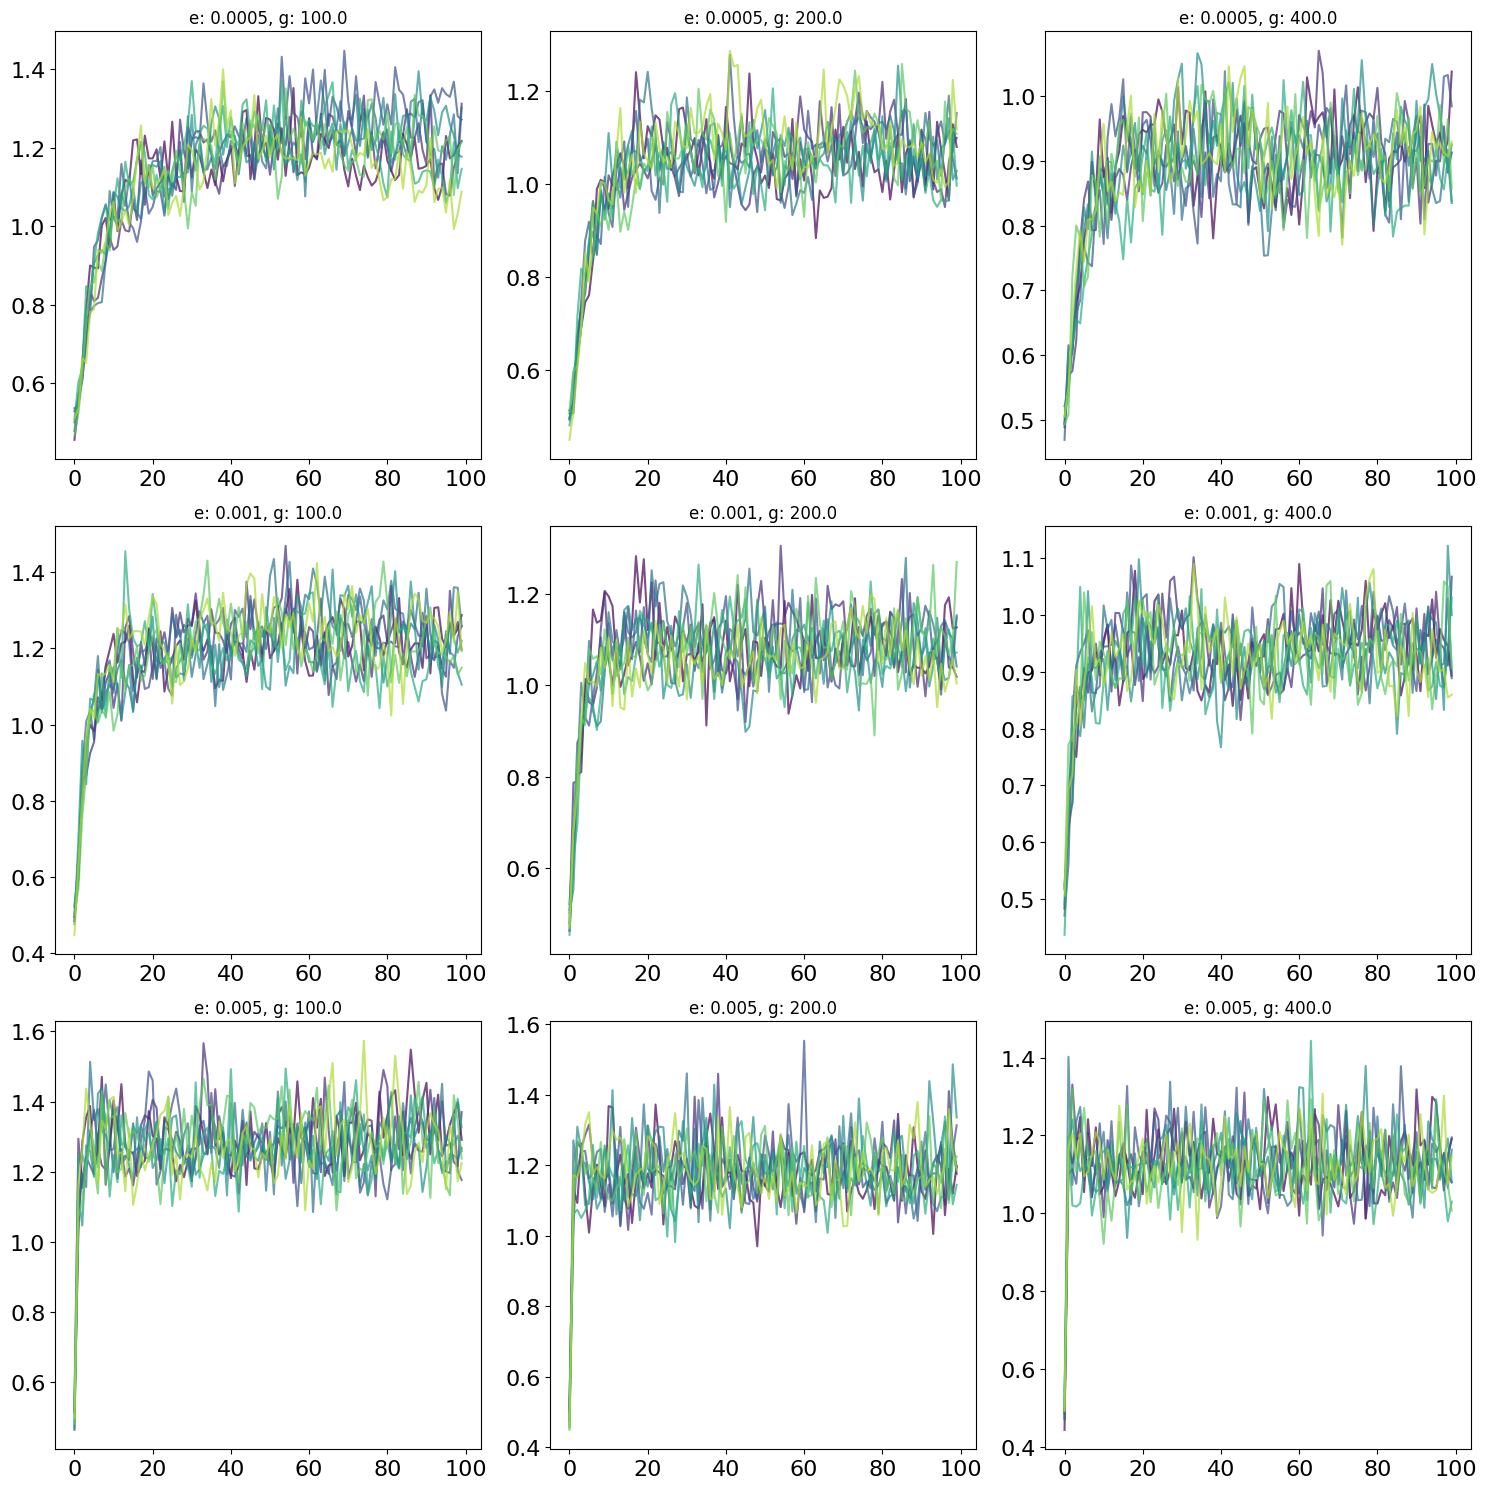

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(eps), len(gammas), figsize=(15, 15))
for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        llc_output = llcs[(e, g)]
        traces = llc_output["loss/trace"]
        # set colormap
        cmap = plt.get_cmap("viridis")
        for color, chain in enumerate(traces):
            ax[i, j].plot(chain, alpha=0.7, color=cmap(color  / len(traces)))
        ax[i, j].set_title(f"e: {e}, g: {g}")

# set fontsize
for a in ax.flatten():
    a.tick_params(axis="both", which="major", labelsize=16)
plt.tight_layout()

In [22]:
llcs[(0.0005, 100.0)].keys()

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

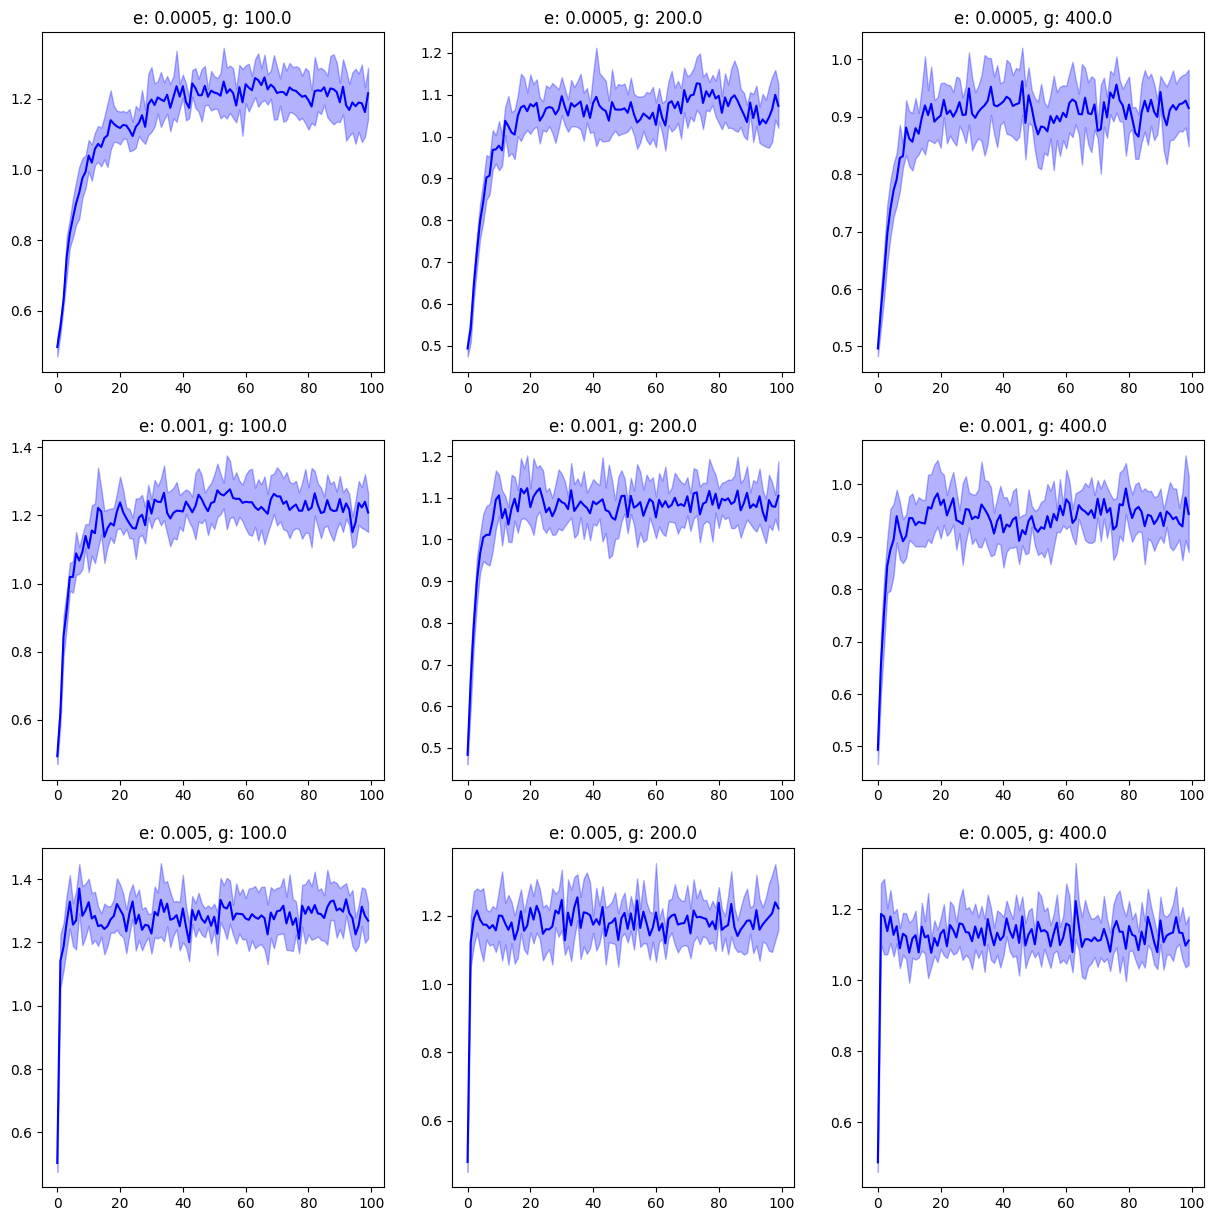

In [24]:
std = {}
mean = {}
for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        llc_output = llcs[(e, g)]
        traces = llc_output["loss/trace"]
        trace_std = np.min(traces, axis=0)
        trace_mean = np.mean(traces, axis=0)
        std[(e, g)] = trace_std
        mean[(e, g)] = trace_mean

fig, ax = plt.subplots(len(eps), len(gammas), figsize=(15, 15))

for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        ax[i, j].plot(mean[(e, g)], color="blue")
        ax[i, j].fill_between(
            np.arange(len(mean[(e, g)])),
            mean[(e, g)] - std[(e, g)],
            mean[(e, g)] + std[(e, g)],
            color="blue",
            alpha=0.3,
        )
        ax[i, j].set_title(f"e: {e}, g: {g}")

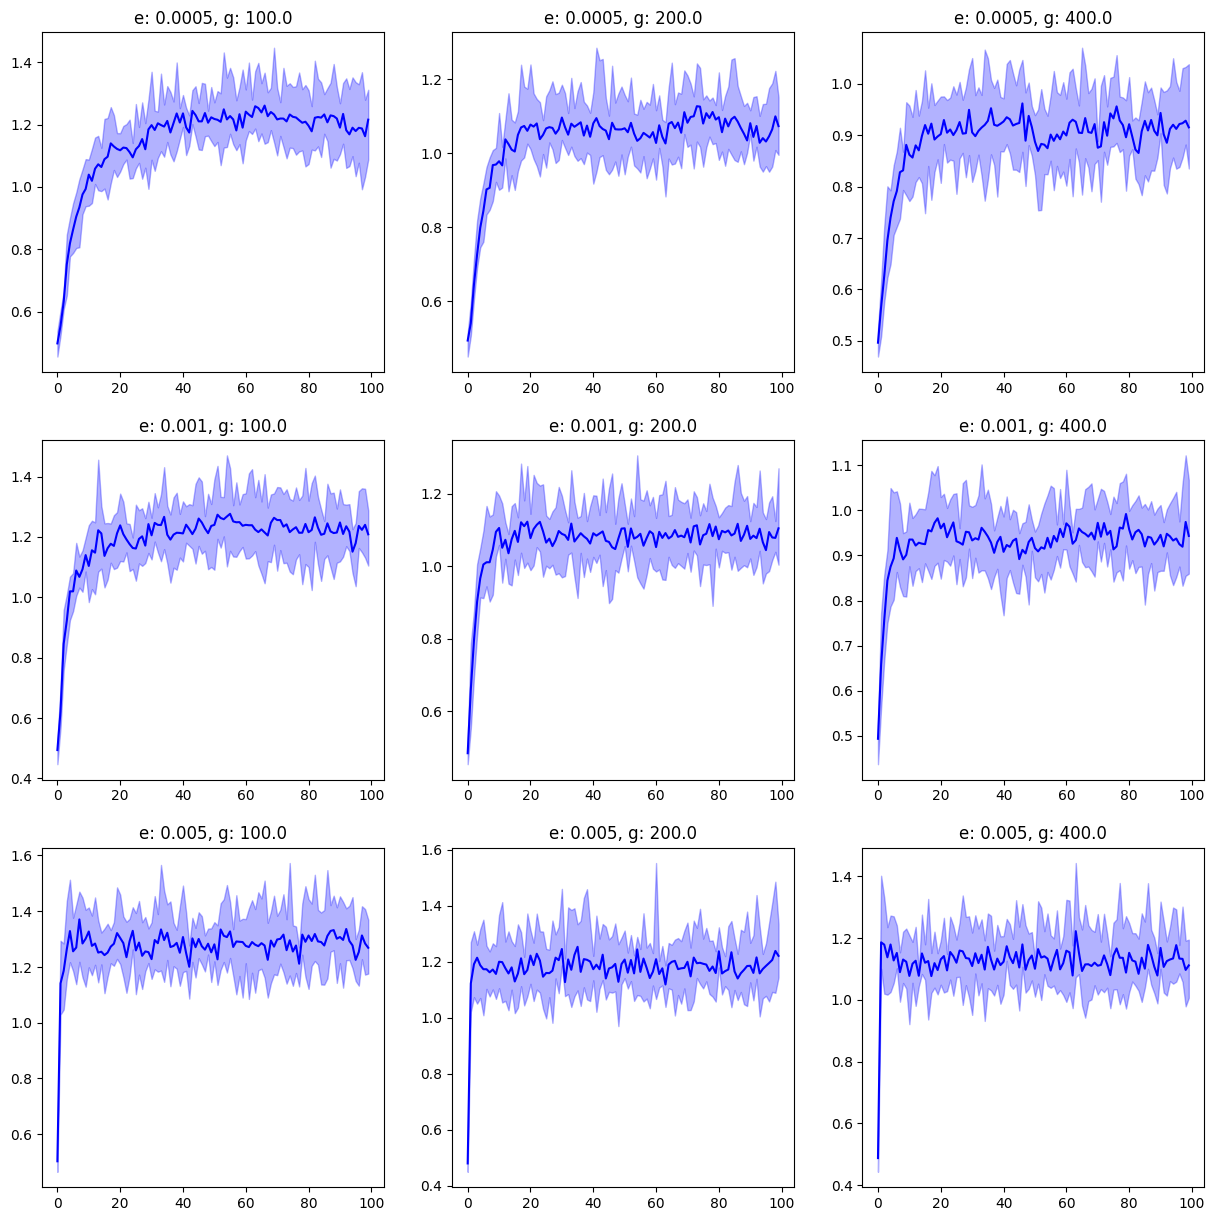

In [25]:
mins = {}
maxs = {}
for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        llc_output = llcs[(e, g)]
        traces = llc_output["loss/trace"]
        trace_min = np.min(traces, axis=0)
        trace_max = np.max(traces, axis=0)
        mins[(e, g)] = trace_min
        maxs[(e, g)] = trace_max

fig, ax = plt.subplots(len(eps), len(gammas), figsize=(15, 15))

for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        ax[i, j].plot(mean[(e, g)], color="blue")
        ax[i, j].fill_between(
            np.arange(len(mean[(e, g)])),
            mins[(e, g)],
            maxs[(e, g)],
            color="blue",
            alpha=0.3,
        )
        ax[i, j].set_title(f"e: {e}, g: {g}")